In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas
import sys
import scipy
sys.path.append('/Users/ruby/EoR/pyuvdata')
from pyuvdata import UVData
import scipy.optimize
import scipy.stats

In [2]:
path = '/Users/ruby/EoR/compact_redundant_array_sim_May2020'
uvw_match_tolerance = 1e-12

In [3]:
# Load data from pyuvsim simulation:
data_sim_compact = UVData()
data_sim_compact.read_uvh5('{}/square_grid_sim__results.uvh5'.format(path))

# Remove autos
data_sim_compact.select(ant_str='cross')
# Use only XX polarizations
data_sim_compact.select(polarizations=[-5])

# Convert baselines to have u>0
data_sim_compact.conjugate_bls(convention='u>0', use_enu=False, uvw_tol=0.01)

baseline_groups, vec_bin_centers, lengths, conjugates = data_sim_compact.get_redundancies(
    tol=0.1, use_antpos=False, include_conjugates=True, include_autos=True, conjugate_bls=False
)

# Define constants
N_red_baselines = np.shape(baseline_groups)[0]
N_ants = data_sim_compact.Nants_data

# Reorder visibilities
data_sim_vis_no_noise = np.zeros(N_red_baselines, dtype=np.complex_)
for red_group in range(N_red_baselines):
    found_group = False
    for red_group_2 in range(N_red_baselines):
        if np.abs(np.sum(data_sim_compact.uvw_array[red_group]-vec_bin_centers[red_group_2])) < uvw_match_tolerance:
            data_sim_vis_no_noise[red_group] = data_sim_compact.data_array[red_group_2, 0, 0, 0]
            found_group = True
            break
    if not found_group:
        print('ERROR: Visibility not found.')

Telescope square_grid is not in known_telescopes.


In [4]:
# Make noiseless data
data_sim_expanded = data_sim_compact.copy()
data_sim_expanded.inflate_by_redundancy()

# Define constant
N_vis = data_sim_expanded.Nbls

Missing some redundant groups. Filling in available data.


In [5]:
# Load data with missing sources from pyuvsim simulation:
model_sim = UVData()
model_sim.read_uvh5('{}/square_grid_100mjy_sim_results.uvh5'.format(path))
#Added for testing
#model_sim.read_uvh5('{}/square_grid_sim__results.uvh5'.format(path))

# Remove autos
model_sim.select(ant_str='cross')
# Use only XX polarizations
model_sim.select(polarizations=[-5])

# Convert baselines to have u>0
model_sim.conjugate_bls(convention='u>0', use_enu=False, uvw_tol=0.01)

model_sim_visibilities = np.zeros(N_red_baselines, dtype=np.complex_)
for red_group in range(N_red_baselines):
    found_group = False
    for red_group_2 in range(N_red_baselines):
        if np.abs(np.sum(model_sim.uvw_array[red_group]-vec_bin_centers[red_group_2])) < uvw_match_tolerance:
            model_sim_visibilities[red_group] = model_sim.data_array[red_group_2, 0, 0, 0]
            found_group = True
            break
    if not found_group:
        print('ERROR: Visibility not found.')

Telescope square_grid is not in known_telescopes.


In [6]:
# Create the baseline covariance matrix
baseline_cov_array = np.diag(np.full(N_red_baselines, 1.))
min_bl_length = 14.
tolerance = .01
for bl_1 in range(N_red_baselines):
    for bl_2 in [ind for ind in range(N_red_baselines) if ind != bl_1]:
        bl_separation_sq = (
            (vec_bin_centers[bl_1, 0]-vec_bin_centers[bl_2, 0])**2
            + (vec_bin_centers[bl_1, 1]-vec_bin_centers[bl_2, 1])**2
        )
        if (min_bl_length-tolerance)**2 <= bl_separation_sq <= (min_bl_length+tolerance)**2:
            baseline_cov_array[bl_1, bl_2] = 0.1617
        elif 2*(min_bl_length-tolerance)**2 <= bl_separation_sq <= 2*(min_bl_length+tolerance)**2:
            baseline_cov_array[bl_1, bl_2] = 0.0176
# Invert the matrix
baseline_cov_inv = np.linalg.inv(baseline_cov_array)

# Create the A matrix
a_mat = np.zeros((N_vis, N_red_baselines))
for vis_ind in range(N_vis):
    for red_group in range(N_red_baselines):
        if np.abs(np.sum(data_sim_expanded.uvw_array[vis_ind]-vec_bin_centers[red_group])) < uvw_match_tolerance:
            a_mat[vis_ind, red_group] = 1
            break
        
# Create gains expand matrices
gains_exp_mat_1 = np.zeros((N_vis, N_ants), dtype=np.int)
gains_exp_mat_2 = np.zeros((N_vis, N_ants), dtype=np.int)
for baseline in range(N_vis):
    gains_exp_mat_1[baseline, data_sim_expanded.ant_1_array[baseline]] = 1
    gains_exp_mat_2[baseline, data_sim_expanded.ant_2_array[baseline]] = 1

In [127]:
print(np.sum(a_mat, axis=0))

[30. 24. 18. 12.  6. 30. 25. 20. 15. 10.  5. 24. 20. 16. 12.  8.  4. 18.
 15. 12.  9.  6.  3. 12. 10.  8.  6.  4.  2.  6.  5.  4.  3.  2.  1. 25.
 20. 15. 10.  5. 20. 16. 12.  8.  4. 15. 12.  9.  6.  3. 10.  8.  6.  4.
  2.  5.  4.  3.  2.  1.]


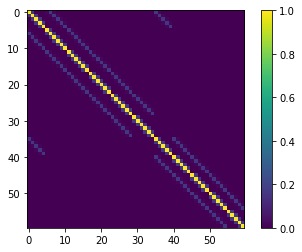

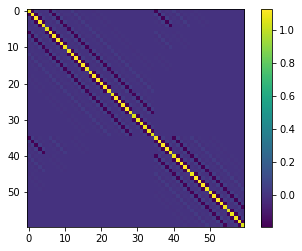

In [8]:
plt.imshow(baseline_cov_array)
plt.colorbar()
plt.show()

plt.imshow(baseline_cov_inv)
plt.colorbar()
plt.show()

In [108]:
def cost_function(
    x, 
    N_red_baselines, N_ants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):

    fitted_visibilities = x[-2*N_red_baselines:-N_red_baselines]+1j*x[-N_red_baselines:]
    gains = x[:N_ants]+1j*x[N_ants:2*N_ants]
    
    cost = calc_negloglikelihood(
        gains, fitted_visibilities, data_visibilities, model_visibilities, 
        baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev, model_stddev
    )
    return cost


def calc_negloglikelihood(
    gains, fitted_visibilities, data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev, model_stddev
):
    
    # To improve numerical performance
    scaling_factor = get_scaling_factor(data_stddev, model_stddev)
    
    vis_diff = fitted_visibilities-model_visibilities
    prior = np.abs(np.dot(np.matmul(np.conj(vis_diff), baseline_cov_inv), vis_diff))
    
    fitted_visibilities_expanded = np.matmul(a_mat, fitted_visibilities)
    gains_expanded = np.matmul(gains_exp_mat_1, gains)*np.matmul(gains_exp_mat_2, np.conj(gains))
    prob = np.sum(np.abs(data_visibilities - gains_expanded*fitted_visibilities_expanded)**2)
    
    return scaling_factor*(prob/data_stddev**2. + prior/model_stddev**2.)

def get_scaling_factor(data_stddev, model_stddev):
    
    if model_stddev > 1e3:
        #scaling_factor = model_stddev**2.
        scaling_factor = 1.
    else:
        scaling_factor = 1.
    return scaling_factor

In [10]:
def jac_function(x, 
    N_red_baselines, N_ants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):
    
    fitted_visibilities = x[-2*N_red_baselines:-N_red_baselines]+1j*x[-N_red_baselines:]
    gains = x[:N_ants]+1j*x[N_ants:2*N_ants]
    
    gains_grad = calc_gains_grad(
        gains, fitted_visibilities, data_visibilities,
        a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev, model_stddev
    )
    vis_grad = calc_vis_grad(
        gains, fitted_visibilities, data_visibilities, model_visibilities, 
        baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev, model_stddev
    )
    
    grads = np.zeros(N_ants*2+N_red_baselines*2)
    grads[:N_ants] = np.real(gains_grad)
    grads[N_ants:2*N_ants] = np.imag(gains_grad)
    grads[-2*N_red_baselines:-N_red_baselines] = np.real(vis_grad)
    grads[-N_red_baselines:] = np.imag(vis_grad)
    return grads


def calc_gains_grad(
    gains, fitted_visibilities, data_visibilities,
    a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev, model_stddev
):
    
    # To improve numerical performance
    scaling_factor = get_scaling_factor(data_stddev, model_stddev)

    gains1_expanded = np.matmul(gains_exp_mat_1, gains)
    gains2_expanded = np.matmul(gains_exp_mat_2, gains)
    vis_expanded = np.matmul(a_mat, fitted_visibilities)

    gains_grad_term_1 = (
        np.abs(gains1_expanded*vis_expanded)**2.*gains2_expanded
        - np.conj(data_visibilities)*gains1_expanded*vis_expanded
    )
    gains_grad_term_2 = (
        np.abs(np.conj(gains2_expanded)*vis_expanded)**2.*gains1_expanded
        - data_visibilities*gains2_expanded*np.conj(vis_expanded)
    )
    gains_grad = (2./data_stddev**2.)*(
        np.matmul(gains_exp_mat_2.T, gains_grad_term_1)
        + np.matmul(gains_exp_mat_1.T, gains_grad_term_2)
    )

    return scaling_factor*gains_grad


def calc_vis_grad(
    gains, fitted_visibilities, data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev, model_stddev
):
    
    # To improve numerical performance
    scaling_factor = get_scaling_factor(data_stddev, model_stddev)

    vis_diff = fitted_visibilities-model_visibilities
    gains1_expanded = np.matmul(gains_exp_mat_1, gains)
    gains2_expanded = np.matmul(gains_exp_mat_2, gains)
    gains_expanded = gains1_expanded*np.conj(gains2_expanded)
    
    vis_grad_term_1 = (2./data_stddev**2.) * (
        np.matmul(np.abs(gains_expanded)**2, a_mat**2.)*fitted_visibilities
    )
    vis_grad_term_2 = (-2./data_stddev**2.) * (
        np.matmul(data_visibilities*np.conj(gains_expanded), a_mat)
    )
    vis_grad_term_3 = (2./model_stddev**2.) * np.matmul(baseline_cov_inv, vis_diff)
    vis_grad = vis_grad_term_1 + vis_grad_term_2 + vis_grad_term_3

    return scaling_factor*vis_grad

In [11]:
# Check that the gradients are correct

step_size = 1.
use_ind = 0
gains_test_1 = 1.+np.random.normal(0, .01, N_ants)+1j*np.random.normal(0, .01, N_ants)
#gains_test_1 = np.full(N_ants, 0.+0.j)
gains_test_1[use_ind+1] = 1.
gains_test_2 = np.copy(gains_test_1)
gains_test_2[use_ind] += step_size
vis_test = model_sim_visibilities+np.random.normal(0, .01, N_red_baselines)+1j*np.random.normal(0, .01, N_red_baselines)
vis_test_1 = np.copy(model_sim_visibilities)
vis_test_2 = np.copy(model_sim_visibilities)
#vis_test_2[use_ind] += step_size
#data_test = np.matmul(a_mat, model_sim_visibilities)
data_test = np.zeros(N_vis)

data_stddev_use = .2
model_stddev_use = model_stddev_sim

#baseline_cov_inv = np.diag(np.full(np.shape(baseline_cov_inv)[0], 1.))
        
# Check the cost function to ensure it's actually minimizing
cost1 = calc_negloglikelihood(
    gains_test_1, vis_test_1, data_test, model_sim_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev_use, model_stddev_use
)
cost2 = calc_negloglikelihood(
    gains_test_2, vis_test_2, data_test, model_sim_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev_use, model_stddev_use
)
grad_calculated = (cost2-cost1)/step_size

gains_grad = calc_gains_grad(
    (gains_test_1+gains_test_2)/2., (vis_test_1+vis_test_2)/2., data_test,
    a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev_use, model_stddev_use
)
vis_grad = calc_vis_grad(
    (gains_test_1+gains_test_2)/2., (vis_test_1+vis_test_2)/2., data_test, model_sim_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev_use, model_stddev_use
)

print(grad_calculated)
print(gains_grad[use_ind])
print(vis_grad[use_ind])

NameError: name 'model_stddev_sim' is not defined

In [12]:
def produce_kde(data, xvals, yvals):
    
    data_real = np.real(data).flatten()
    data_imag = np.imag(data).flatten()
    rvs = np.append(data_real[:,np.newaxis],
                    data_imag[:,np.newaxis],
                    axis=1)

    kde = scipy.stats.kde.gaussian_kde(rvs.T)

    # Regular grid to evaluate KDE upon
    x,y = np.meshgrid(xvals, yvals)
    grid_coords = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)

    kde_vals = kde(grid_coords.T)
    kde_vals = kde_vals.reshape(len(xvals),len(yvals))
    
    percent_vals = np.zeros_like(kde_vals)
    kde_total = np.sum(kde_vals)
    running_total = 0.
    for val in np.sort(kde_vals.flatten())[::-1]: # Sort values in reverse order
        percent_vals[np.where(kde_vals == val)] = running_total/kde_total
        running_total += val
    
    return kde_vals, percent_vals

0.4092157966687509


NameError: name 'data_stddev' is not defined

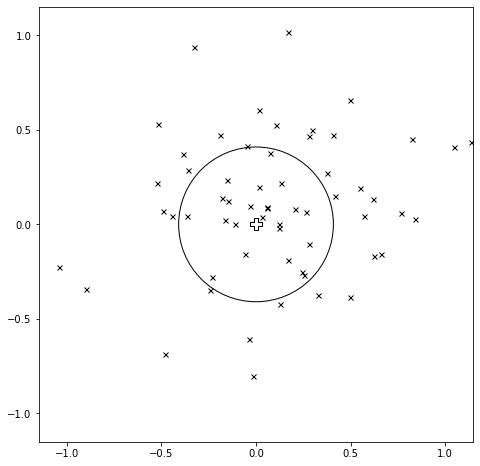

In [13]:
# Calculate deviation between model and true data
model_stddev_sim = np.sqrt(np.mean(np.abs(model_sim_visibilities-data_sim_vis_no_noise)**2)/2.)
print(model_stddev_sim)

plt.figure(figsize=[10,8])
plt.plot(
    np.real(model_sim_visibilities-data_sim_vis_no_noise).flatten(), 
    np.imag(model_sim_visibilities-data_sim_vis_no_noise).flatten(),
    'x', color='black', markersize=5
)
plt.axis('square')
plt.xlim(-1.15,1.15)
plt.ylim(-1.15,1.15)
#cont = plt.contour(bins, bins, percent_plot, levels=[.5,.9], colors='white', linestyles=['solid','dashed'], linewidths=1)
plt.scatter([0],[0],marker='P',color='white',edgecolors='black',s=150)
circle = plt.Circle((0, 0), model_stddev_sim, fill=False, color='black')
plt.gcf().gca().add_artist(circle)
circle = plt.Circle((0, 0), data_stddev, fill=False, color='blue', linestyle='dashed')
plt.gcf().gca().add_artist(circle)
#plt.clabel(cont, inline=2, fontsize=10)
plt.xlabel('Model Visibility Error, Real Part (Jy)')
plt.ylabel('Model Visibility Error, Imaginary Part (Jy)')
#plt.title(data_titles[data_set_ind])
plt.tight_layout() # Ensure that axes labels don't get cut off
#plt.savefig('{}/{}'.format(save_path, 'model_vis_scatter.png'),dpi=600)
plt.show()

In [14]:
def optimize_with_scipy_simple(
    data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    N_red_baselines, N_ants, data_stddev, model_stddev,
    gains_init=None, fitted_visibilities_init=None
):

    method = 'Powell'
    maxiter = 100000
    xtol = 1e-20
    ftol = 1e-20
    
    if gains_init is None: # Initialize the gains to 1
        gains_init = np.full(N_ants, 1.+0.j)
    if fitted_visibilities_init is None: # Initialize the fitted visibilities to the model visibilities
        fitted_visibilities_init = model_visibilities
    # Expand the initialized values
    x0 = np.concatenate((
        np.real(gains_init), np.imag(gains_init),
        np.real(fitted_visibilities_init), np.imag(fitted_visibilities_init)
    ))

    # Minimize the cost function
    result = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            N_red_baselines, N_ants, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities,
            data_stddev, model_stddev
        ),
        method=method, options={'xtol': xtol, 'ftol': ftol, 'maxiter': maxiter}
    )
    print(result.message)

    gains_fit = result.x[:N_ants]+1j*result.x[N_ants:2*N_ants]
    vis_fit = result.x[-2*N_red_baselines:-N_red_baselines]+1j*result.x[-N_red_baselines:]
    # Ensure that the angle of the gains is mean-zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)

    return gains_fit, vis_fit

In [57]:
def optimize_with_scipy_jac(
    data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    N_red_baselines, N_ants, data_stddev, model_stddev,
    gains_init=None, fitted_visibilities_init=None
):

    #method = 'BFGS' #fails catastrophically for red cal
    #method = 'Nelder-Mead' #doesn't use gradient
    method = 'CG' #shows offset in amplitude
    #method = 'Newton-CG' #not accurate, doesn't change the visibilities for red cal
    #method = 'L-BFGS-B'#shows offset in amplitude
    #method = 'COBYLA' #doesn't use gradient
    #method = 'SLSQP'
    maxiter = 100000
    #xtol = 1e-20

    if gains_init is None: # Initialize the gains to 1
        gains_init = np.full(N_ants, 1.+0.j)
    if fitted_visibilities_init is None: # Initialize the fitted visibilities to the model visibilities
        fitted_visibilities_init = model_visibilities
    # Expand the initialized values
    x0 = np.concatenate((
        np.real(gains_init), np.imag(gains_init),
        np.real(fitted_visibilities_init), np.imag(fitted_visibilities_init)
    ))

    # Minimize the cost function
    result = scipy.optimize.minimize(
        cost_function, x0, jac=jac_function,
        args=(
            N_red_baselines, N_ants, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities,
            data_stddev, model_stddev
        ),
        method=method, options={'disp': True, 'maxiter': maxiter}
    )
    print(result.message)

    gains_fit = result.x[:N_ants]+1j*result.x[N_ants:2*N_ants]
    vis_fit = result.x[-2*N_red_baselines:-N_red_baselines]+1j*result.x[-N_red_baselines:]
    # Ensure that the angle of the gains is mean-zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)

    return gains_fit, vis_fit

In [16]:
def gains_cost_function(
    gains_expanded, 
    fitted_visibilities, N_red_baselines, N_ants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):

    gains = gains_expanded[:N_ants]+1j*gains_expanded[N_ants:]
    
    cost = calc_negloglikelihood(
        gains, fitted_visibilities, data_visibilities, model_visibilities, 
        baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev, model_stddev
    )
    return cost


def gains_jac_function(
    gains_expanded, 
    fitted_visibilities, N_red_baselines, N_ants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):

    gains = gains_expanded[:N_ants]+1j*gains_expanded[N_ants:]
    gains_grad = calc_gains_grad(
        gains, fitted_visibilities, data_visibilities,
        a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev, model_stddev
    )
    gains_grad_expanded = np.concatenate((np.real(gains_grad), np.imag(gains_grad)))
    return gains_grad_expanded


def vis_cost_function(
    vis_expanded, 
    gains, N_red_baselines, N_ants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):

    fitted_visibilities = vis_expanded[:N_red_baselines]+1j*vis_expanded[N_red_baselines:]
    cost = calc_negloglikelihood(
        gains, fitted_visibilities, data_visibilities, model_visibilities, 
        baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev, model_stddev
    )
    return cost 


def vis_jac_function(
    vis_expanded, 
    gains, N_red_baselines, N_ants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):

    fitted_visibilities = vis_expanded[:N_red_baselines]+1j*vis_expanded[N_red_baselines:]
    vis_grad = calc_vis_grad(
        gains, fitted_visibilities, data_visibilities, model_visibilities, 
        baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev, model_stddev
    )
    vis_grad_expanded = np.concatenate((np.real(vis_grad), np.imag(vis_grad)))
    return vis_grad_expanded 

In [17]:
def optimize_in_two_parts(
    data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    N_red_baselines, N_ants, data_stddev, model_stddev,
    gains_init=None, fitted_visibilities_init=None
):

    method = 'BFGS'
    n_iter = 5000

    if gains_init is None: # Initialize the gains to 1
        gains_init = np.full(N_ants, 1.+0.j)
    if fitted_visibilities_init is None: # Initialize the fitted visibilities to the model visibilities
        fitted_visibilities_init = model_visibilities
    
    fitted_visibilities = np.copy(fitted_visibilities_init)
    gains = np.copy(gains_init)
    
    for iter_ind in range(n_iter):
    
        # Calculate gains
        # Expand the initialized values
        gains_expanded = np.concatenate((
            np.real(gains), np.imag(gains)
        ))
        # Minimize the gains cost function
        result = scipy.optimize.minimize(
            gains_cost_function, gains_expanded, jac=gains_jac_function,
            args=(
                fitted_visibilities, N_red_baselines, N_ants, baseline_cov_inv, 
                model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities,
                data_stddev, model_stddev
            ),
            method=method, options={'disp': False}
        )
        # Update gains
        gains = result.x[:N_ants]+1j*result.x[N_ants:]
        # Ensure that the angle of the gains is mean-zero
        avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains))), np.mean(np.cos(np.angle(gains))))
        gains *= np.cos(avg_angle) - 1j*np.sin(avg_angle)

        # Calculate visibilities
        # Expand the initialized values
        vis_expanded = np.concatenate((
            np.real(fitted_visibilities), np.imag(fitted_visibilities)
        ))
        result = scipy.optimize.minimize(
            vis_cost_function, vis_expanded, jac=vis_jac_function,
            args=(
                gains, N_red_baselines, N_ants, baseline_cov_inv, 
                model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities,
                data_stddev, model_stddev
            ),
            method=method, options={'disp': False}
        )
        # Update visibilities
        fitted_visibilities = result.x[:N_red_baselines]+1j*result.x[N_red_baselines:]    

    return gains, fitted_visibilities

In [18]:
def optimize_with_scipy_constrained(
    data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    N_red_baselines, N_ants, data_stddev, model_stddev,
    gains_init=None, fitted_visibilities_init=None
):

    #method = 'BFGS'
    method = 'trust-constr'
    maxiter = 1e5 # Defaults to 1000

    if gains_init is None: # Initialize the gains to 1
        gains_init = np.full(N_ants, 1.+0.j)
    if fitted_visibilities_init is None: # Initialize the fitted visibilities to the model visibilities
        fitted_visibilities_init = model_visibilities
    # Expand the initialized values
    x0 = np.concatenate((
        np.real(gains_init), np.imag(gains_init),
        np.real(fitted_visibilities_init), np.imag(fitted_visibilities_init)
    ))
    
    # Produce constraint
    constraint_vec = np.zeros(2*N_ants + 2*N_red_baselines)
    constraint_vec[N_ants:2*N_ants] = 1
    constraint = scipy.optimize.LinearConstraint(constraint_vec.T, 0, 0)

    # Minimize the cost function
    result = scipy.optimize.minimize(
        cost_function, x0, jac=jac_function,
        constraints=[constraint],
        args=(
            N_red_baselines, N_ants, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities,
            data_stddev, model_stddev
        ),
        method=method, options={'disp': True, 'maxiter': maxiter}
    )
    print(result.message)

    gains_fit = result.x[:N_ants]+1j*result.x[N_ants:2*N_ants]
    vis_fit = result.x[-2*N_red_baselines:-N_red_baselines]+1j*result.x[-N_red_baselines:]
    # Ensure that the angle of the gains is mean-zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)

    return gains_fit, vis_fit

In [95]:
def optimize_with_gradient_descent(
    data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    N_red_baselines, N_ants, data_stddev, model_stddev,
    gains_init=None, fitted_visibilities_init=None
):
    
    n_iter = 10000
    learning_rate = .1
    term_condition = .035
    
    if gains_init is None: # Initialize the gains to 1
        gains_init = np.full(N_ants, 1.+0.j)
    if fitted_visibilities_init is None: # Initialize the fitted visibilities to the model visibilities
        fitted_visibilities_init = model_visibilities
    
    # Initialize values
    gains_fit = np.copy(gains_init)
    vis_fit = np.copy(fitted_visibilities_init)
    
    iter_ind = 0
    term_condition_fulfilled = 0
    #while term_condition_fulfilled < 3:
    for iter_ind in range(n_iter):
        
        # Check the cost function to ensure it's actually minimizing
        negloglikelihood = calc_negloglikelihood(
            gains_fit, vis_fit, data_visibilities, model_visibilities, 
            baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
            data_stddev, model_stddev
        )
        
        gains_grad = calc_gains_grad(
            gains_fit, vis_fit, data_visibilities,
            a_mat, gains_exp_mat_1, gains_exp_mat_2,
            data_stddev, model_stddev
        )
        vis_grad = calc_vis_grad(
            gains_fit, vis_fit, data_visibilities, model_visibilities, 
            baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
            data_stddev, model_stddev
        )
        
        if iter_ind > 0: # Use the Barzilai–Borwein method of determining step size
            numerator = np.abs(
                np.sum((gains_fit-gains_fit_old)*(gains_grad-gains_grad_old)) 
                + np.sum((vis_fit-vis_fit_old)*(vis_grad-vis_grad_old))
            )
            denominator = np.sum(np.abs(gains_grad-gains_grad_old)**2.) + np.sum(np.abs(vis_grad-vis_grad_old)**2.)
            step_size = numerator/denominator
        else: # Arbitrary, but not too big
            step_size = np.min([data_stddev, model_stddev])/(
                1000.*np.sqrt(np.sum(np.abs(gains_grad)**2.) + np.sum(np.abs(vis_grad**2.)))
            )
        
        gains_fit_old = np.copy(gains_fit)
        vis_fit_old = np.copy(vis_fit)
        gains_grad_old = np.copy(gains_grad)
        vis_grad_old = np.copy(vis_grad)
        
        gains_fit -= learning_rate*step_size*gains_grad
        vis_fit -= learning_rate*step_size*vis_grad

        # Ensure that the angle of the gains is mean-zero
        avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
        gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)
        
        # Check termination condition
        #print(learning_rate*step_size*np.sqrt(np.sum(np.abs(gains_grad)**2)+np.sum(np.abs(vis_grad)**2)))
        if learning_rate*step_size*np.sqrt(np.sum(np.abs(gains_grad)**2)+np.sum(np.abs(vis_grad)**2)) < term_condition:
            term_condition_fulfilled += 1
        else:
            term_condition_fulfilled = 0
            
        iter_ind += 1

    return gains_fit, vis_fit

In [20]:
data_stddev_use = .2
model_stddev_use = model_stddev_sim

data_visibilities = data_vis_noisy[:, 0]

#Added for testing
#baseline_cov_inv = np.diag(np.full(np.shape(baseline_cov_inv)[0], 1.))

gains_fit, vis_fit = optimize_with_gradient_descent(
    data_visibilities, model_sim_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    N_red_baselines, N_ants, data_stddev_use, model_stddev_use,
    gains_init=None, fitted_visibilities_init=None
)
print(gains_fit)

NameError: name 'data_vis_noisy' is not defined

In [143]:
# Generate noisy data
n_trials=100
#n_trials=1
data_stddev = .3
#data_stddev = 0

data_vis_noisy = np.zeros((N_vis, n_trials), dtype=np.complex_)
for trial_ind in range(n_trials):
    data_vis_noisy[:, trial_ind] = (
        data_sim_expanded.data_array[:,0,0,0] 
        + np.random.normal(0, data_stddev, N_vis) 
        + 1j*np.random.normal(0, data_stddev, N_vis)
    )

In [144]:
#model_stddev_sim = .4
#model_stddev_use_vals = [model_stddev_sim/1000000, model_stddev_sim, model_stddev_sim*1000000]
model_stddev_use_vals = [model_stddev_sim/10000, model_stddev_sim, model_stddev_sim*10000]
#model_stddev_use_vals = [model_stddev_sim/100000, model_stddev_sim/10000, model_stddev_sim, model_stddev_sim*10000, model_stddev_sim*100000]
data_stddev_use = data_stddev
#data_stddev_use = .2

gain_vals = np.zeros((N_ants, n_trials, len(model_stddev_use_vals)), dtype=np.complex_)
vis_diff_vals = np.zeros((N_red_baselines, n_trials, len(model_stddev_use_vals)), dtype=np.complex_)

for stddev_ind, model_stddev_use in enumerate(model_stddev_use_vals):

    for trial in range(n_trials):
        print('***Version {}, Trial {}***'.format(stddev_ind+1, trial+1))
        data_visibilities = data_vis_noisy[:, trial]
        
        #Added for testing
        #baseline_cov_inv = np.diag(np.full(np.shape(baseline_cov_inv)[0], 1.))
        data_sim_vis_no_noise_use = np.copy(data_sim_vis_no_noise)
        #data_sim_vis_no_noise_use[0] += 1
        
        gains_fit, vis_fit = optimize_with_scipy_jac(
            data_visibilities, model_sim_visibilities,
            #data_sim_vis_no_noise_use, 
            baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
            N_red_baselines, N_ants, data_stddev_use, model_stddev_use,
            gains_init=None, fitted_visibilities_init=np.matmul(np.linalg.pinv(a_mat), data_visibilities)
        )

        gain_vals[:, trial, stddev_ind] = gains_fit-1
        vis_fit_diff = vis_fit-data_sim_vis_no_noise
        vis_diff_vals[:, trial, stddev_ind] = vis_fit_diff

***Version 1, Trial 1***
         Current function value: 2917.723441
         Iterations: 311
         Function evaluations: 558
         Gradient evaluations: 557
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 2***
         Current function value: 2999.245790
         Iterations: 321
         Function evaluations: 581
         Gradient evaluations: 580
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 3***
         Current function value: 3101.058059
         Iterations: 340
         Function evaluations: 683
         Gradient evaluations: 671
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 4***
         Current function value: 3049.477436
         Iterations: 309
         Function evaluations: 548
         Gradient evaluations: 547
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 5***
         Current function value: 3104.128976
         Iterations: 3

         Current function value: 3167.895156
         Iterations: 466
         Function evaluations: 858
         Gradient evaluations: 847
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 30***
         Current function value: 3133.819988
         Iterations: 398
         Function evaluations: 744
         Gradient evaluations: 733
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 31***
         Current function value: 3131.694683
         Iterations: 359
         Function evaluations: 624
         Gradient evaluations: 623
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 32***
         Current function value: 3130.576894
         Iterations: 508
         Function evaluations: 869
         Gradient evaluations: 868
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 33***
         Current function value: 3102.818058
         Iterations: 487
         Function 

         Current function value: 3097.395119
         Iterations: 488
         Function evaluations: 853
         Gradient evaluations: 852
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 58***
         Current function value: 3224.360154
         Iterations: 340
         Function evaluations: 605
         Gradient evaluations: 604
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 59***
         Current function value: 3096.308267
         Iterations: 299
         Function evaluations: 541
         Gradient evaluations: 540
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 60***
         Current function value: 3150.682607
         Iterations: 394
         Function evaluations: 691
         Gradient evaluations: 690
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 61***
         Current function value: 3023.051431
         Iterations: 397
         Function 

         Current function value: 3061.425254
         Iterations: 332
         Function evaluations: 597
         Gradient evaluations: 596
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 86***
         Current function value: 3171.892197
         Iterations: 390
         Function evaluations: 694
         Gradient evaluations: 693
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 87***
         Current function value: 2967.410956
         Iterations: 276
         Function evaluations: 508
         Gradient evaluations: 507
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 88***
         Current function value: 3057.699299
         Iterations: 390
         Function evaluations: 690
         Gradient evaluations: 689
Desired error not necessarily achieved due to precision loss.
***Version 1, Trial 89***
         Current function value: 3034.257702
         Iterations: 268
         Function 

         Current function value: 1204.004832
         Iterations: 567
         Function evaluations: 961
         Gradient evaluations: 960
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 14***
         Current function value: 1159.761168
         Iterations: 363
         Function evaluations: 641
         Gradient evaluations: 640
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 15***
         Current function value: 1155.726278
         Iterations: 412
         Function evaluations: 733
         Gradient evaluations: 732
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 16***
         Current function value: 1148.285360
         Iterations: 355
         Function evaluations: 617
         Gradient evaluations: 616
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 17***
         Current function value: 1190.804161
         Iterations: 429
         Function 

Optimization terminated successfully.
         Current function value: 1266.672680
         Iterations: 473
         Function evaluations: 830
         Gradient evaluations: 830
Optimization terminated successfully.
***Version 2, Trial 42***
         Current function value: 1163.973789
         Iterations: 406
         Function evaluations: 753
         Gradient evaluations: 742
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 43***
         Current function value: 1115.662828
         Iterations: 451
         Function evaluations: 787
         Gradient evaluations: 786
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 44***
Optimization terminated successfully.
         Current function value: 1190.993856
         Iterations: 495
         Function evaluations: 870
         Gradient evaluations: 870
Optimization terminated successfully.
***Version 2, Trial 45***
         Current function value: 1197.521916
         Iterat

         Current function value: 1132.339411
         Iterations: 498
         Function evaluations: 833
         Gradient evaluations: 832
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 70***
         Current function value: 1203.547098
         Iterations: 465
         Function evaluations: 805
         Gradient evaluations: 804
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 71***
         Current function value: 1121.231437
         Iterations: 529
         Function evaluations: 898
         Gradient evaluations: 897
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 72***
         Current function value: 1218.159328
         Iterations: 516
         Function evaluations: 909
         Gradient evaluations: 908
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 73***
         Current function value: 1255.537281
         Iterations: 506
         Function 

         Current function value: 1270.527135
         Iterations: 472
         Function evaluations: 810
         Gradient evaluations: 809
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 98***
         Current function value: 1177.295127
         Iterations: 503
         Function evaluations: 874
         Gradient evaluations: 873
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 99***
         Current function value: 1151.245481
         Iterations: 475
         Function evaluations: 839
         Gradient evaluations: 838
Desired error not necessarily achieved due to precision loss.
***Version 2, Trial 100***
         Current function value: 1189.466898
         Iterations: 461
         Function evaluations: 865
         Gradient evaluations: 853
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 1***
Optimization terminated successfully.
         Current function value: 1032.096901
     

         Current function value: 1134.154201
         Iterations: 271
         Function evaluations: 492
         Gradient evaluations: 491
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 26***
         Current function value: 1119.417967
         Iterations: 306
         Function evaluations: 533
         Gradient evaluations: 532
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 27***
         Current function value: 1061.208989
         Iterations: 339
         Function evaluations: 655
         Gradient evaluations: 643
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 28***
         Current function value: 1023.960210
         Iterations: 361
         Function evaluations: 630
         Gradient evaluations: 629
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 29***
         Current function value: 1027.801508
         Iterations: 284
         Function 

         Current function value: 1051.173169
         Iterations: 331
         Function evaluations: 581
         Gradient evaluations: 580
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 54***
         Current function value: 1009.340221
         Iterations: 368
         Function evaluations: 612
         Gradient evaluations: 611
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 55***
         Current function value: 1120.826094
         Iterations: 329
         Function evaluations: 581
         Gradient evaluations: 580
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 56***
         Current function value: 1084.613488
         Iterations: 292
         Function evaluations: 518
         Gradient evaluations: 517
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 57***
         Current function value: 1087.495668
         Iterations: 276
         Function 

         Current function value: 1058.151915
         Iterations: 347
         Function evaluations: 665
         Gradient evaluations: 653
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 82***
         Current function value: 1000.603589
         Iterations: 267
         Function evaluations: 484
         Gradient evaluations: 483
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 83***
         Current function value: 1078.040019
         Iterations: 311
         Function evaluations: 574
         Gradient evaluations: 572
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 84***
         Current function value: 1125.753266
         Iterations: 292
         Function evaluations: 530
         Gradient evaluations: 529
Desired error not necessarily achieved due to precision loss.
***Version 3, Trial 85***
         Current function value: 1139.359308
         Iterations: 307
         Function 

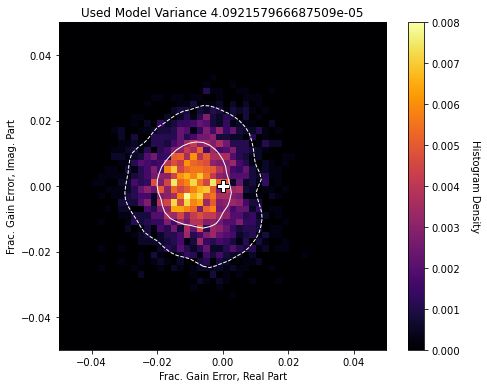

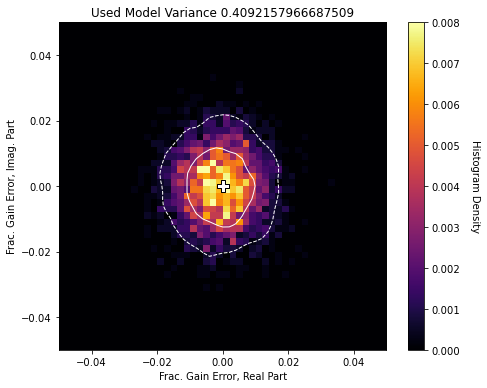

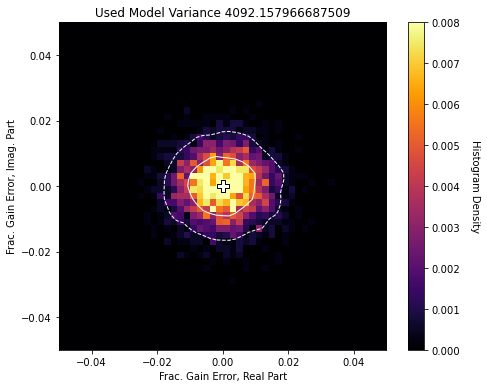

In [145]:
plot_range = .05
nbins = 50
bins = np.linspace(-plot_range, plot_range, num=nbins+1)
colorbar_range = [0, .008]

for data_set_ind in range(len(model_stddev_use_vals)):
    
    plot_data = gain_vals[:, :, data_set_ind]

    hist, x_edges, y_edges = np.histogram2d(
        np.real(plot_data).flatten(), np.imag(plot_data).flatten(), bins=bins
    )
    hist /= np.sum(hist)

    kde, percent_plot = produce_kde(plot_data, bins, bins)

    plt.figure(figsize=[7,5.5])
    plt.imshow(
        hist.T, interpolation='none', origin='lower',
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        vmin=colorbar_range[0], vmax=colorbar_range[1], aspect='equal',
        cmap='inferno'
    )
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Histogram Density', rotation=270, labelpad=20)
    cont = plt.contour(bins, bins, percent_plot, levels=[.5,.9], colors='white', linestyles=['solid','dashed'], linewidths=1)
    plt.scatter([0],[0],marker='P',color='white',edgecolors='black',s=150)
    #plt.clabel(cont, inline=2, fontsize=10)
    plt.xlabel('Frac. Gain Error, Real Part')
    plt.ylabel('Frac. Gain Error, Imag. Part')
    plt.title('Used Model Variance {}'.format(model_stddev_use_vals[data_set_ind]))
    plt.tight_layout() # Ensure that axes labels don't get cut off
    plt.show()

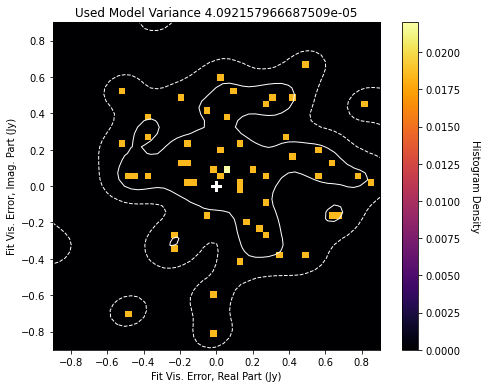

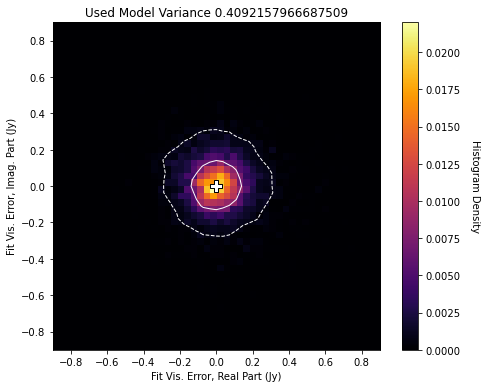

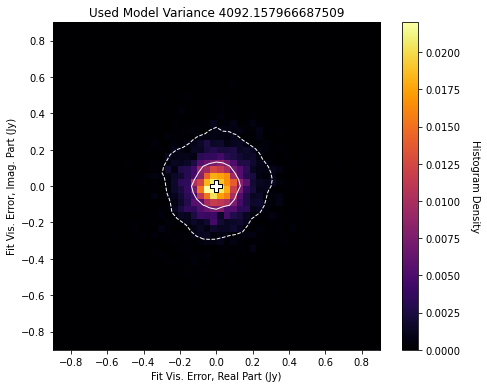

In [146]:
plot_range = .9
nbins = 50
bins = np.linspace(-plot_range, plot_range, num=nbins+1)
colorbar_range = [0, .022]

for data_set_ind in range(len(model_stddev_use_vals)):
    
    plot_data = vis_diff_vals[:, :, data_set_ind]

    hist, x_edges, y_edges = np.histogram2d(
        np.real(plot_data).flatten(), np.imag(plot_data).flatten(), bins=bins
    )
    hist /= np.sum(hist)

    kde, percent_plot = produce_kde(plot_data, bins, bins)

    plt.figure(figsize=[7,5.5])
    plt.imshow(
        hist.T, interpolation='none', origin='lower',
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        vmin=colorbar_range[0], vmax=colorbar_range[1], aspect='equal',
        cmap='inferno'
    )
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Histogram Density', rotation=270, labelpad=20)
    cont = plt.contour(bins, bins, percent_plot, levels=[.5,.9], colors='white', linestyles=['solid','dashed'], linewidths=1)
    plt.scatter([0],[0],marker='P',color='white',edgecolors='black',s=150)
    #plt.clabel(cont, inline=2, fontsize=10)
    plt.xlabel('Fit Vis. Error, Real Part (Jy)')
    plt.ylabel('Fit Vis. Error, Imag. Part (Jy)')
    plt.title('Used Model Variance {}'.format(model_stddev_use_vals[data_set_ind]))
    plt.tight_layout() # Ensure that axes labels don't get cut off
    plt.show()

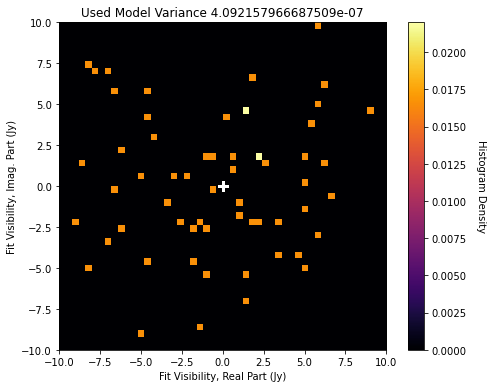

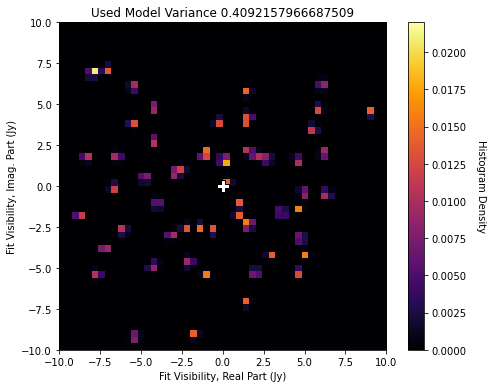

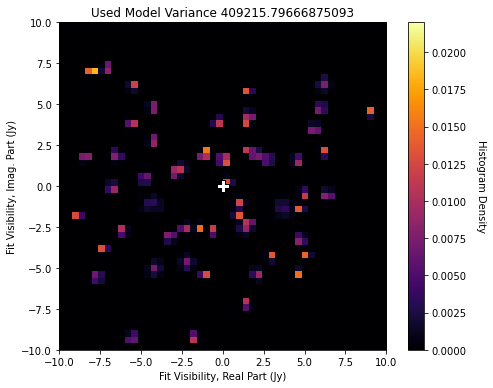

In [105]:
plot_range = 10
nbins = 50
bins = np.linspace(-plot_range, plot_range, num=nbins+1)
colorbar_range = [0, .022]

for data_set_ind in range(len(model_stddev_use_vals)):
    
    plot_data = vis_diff_vals[:, :, data_set_ind]+data_sim_vis_no_noise[:,np.newaxis]

    hist, x_edges, y_edges = np.histogram2d(
        np.real(plot_data).flatten(), np.imag(plot_data).flatten(), bins=bins
    )
    hist /= np.sum(hist)

    kde, percent_plot = produce_kde(plot_data, bins, bins)

    plt.figure(figsize=[7,5.5])
    plt.imshow(
        hist.T, interpolation='none', origin='lower',
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        vmin=colorbar_range[0], vmax=colorbar_range[1], aspect='equal',
        cmap='inferno'
    )
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Histogram Density', rotation=270, labelpad=20)
    #cont = plt.contour(bins, bins, percent_plot, levels=[.5,.9], colors='white', linestyles=['solid','dashed'], linewidths=1)
    plt.scatter([0],[0],marker='P',color='white',edgecolors='black',s=150)
    #plt.clabel(cont, inline=2, fontsize=10)
    plt.xlabel('Fit Visibility, Real Part (Jy)')
    plt.ylabel('Fit Visibility, Imag. Part (Jy)')
    plt.title('Used Model Variance {}'.format(model_stddev_use_vals[data_set_ind]))
    plt.tight_layout() # Ensure that axes labels don't get cut off
    plt.show()

0.992800234305986
[3.27500499e+13 1.96545485e+13 1.00084273e+13 3.66018725e+12
 4.64594402e+11 2.82406109e+11 2.98011030e+12 8.42967698e+12
 1.65083214e+13 2.70982781e+13 4.00865858e+13 5.53648820e+13
 7.28292071e+13]


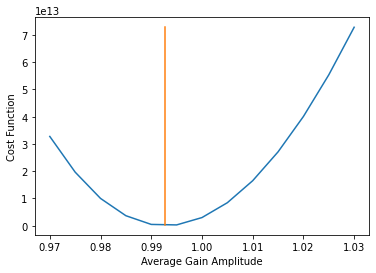

1.0000286022525413
[1694.8108585  1676.84760628 1662.48174885 1651.55693787 1643.92326774
 1639.43699458 1637.96026858 1639.36087882 1643.51201007 1650.29201099
 1659.58417298 1671.27651932 1685.26160405]


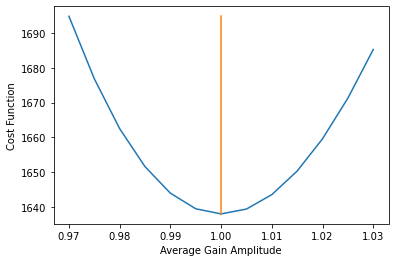

0.9959133846929922
[2.57860982e+14 2.57860982e+14 2.57860982e+14 2.57860982e+14
 2.57860982e+14 2.57860982e+14 2.57860982e+14 2.57860982e+14
 2.57860982e+14 2.57860982e+14 2.57860982e+14 2.57860982e+14
 2.57860982e+14]


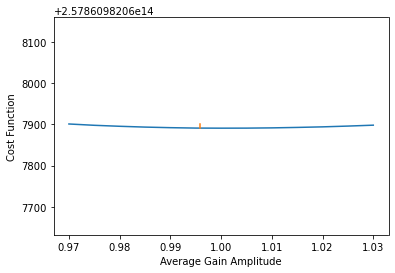

In [106]:
plt.figure()
for stddev_ind in range(3):
    use_trial = 0
    gains = gain_vals[:, use_trial, stddev_ind]+1
    visibilities = vis_diff_vals[:, use_trial, stddev_ind] + data_sim_vis_no_noise
    mean_gain_amp = np.mean(np.abs(gains))
    print(mean_gain_amp)
    use_gain_amps = np.arange(1.-.03, 1.+.03, .005)
    cost_function_result = np.zeros(np.shape(use_gain_amps))
    for ind, use_gain_amp in enumerate(use_gain_amps):
        scaled_gains = gains*use_gain_amp/mean_gain_amp
        scaled_visibilities = visibilities*(mean_gain_amp/use_gain_amp)**2.
        #print(mean_gain_amp)
        x_result = np.concatenate((
            np.real(scaled_gains), np.imag(scaled_gains),
            np.real(scaled_visibilities), np.imag(scaled_visibilities)
        ))

        cost_function_result[ind] = cost_function(
            x_result, 
            N_red_baselines, N_ants, baseline_cov_inv, model_sim_visibilities, a_mat,
            gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev_use, model_stddev_use_vals[stddev_ind]
        )
    print(cost_function_result)
    cost_function_result_scaled = (cost_function_result-np.min(cost_function_result))/(np.max(cost_function_result)-np.min(cost_function_result))
    plt.plot(use_gain_amps, cost_function_result)
    plt.plot([mean_gain_amp,mean_gain_amp], [np.min(cost_function_result),np.max(cost_function_result)])
    plt.xlabel('Average Gain Amplitude')
    plt.ylabel('Cost Function')
    #plt.ylim([0,1])
    plt.show()

[5.71157792e+13 3.90538484e+13 2.46124105e+13 1.36341070e+13
 5.96806378e+12 1.46960820e+12 3.37874361e+03 1.42617427e+12
 5.62049675e+12 1.24605305e+13 2.18288132e+13 3.36126453e+13
 4.77038870e+13]


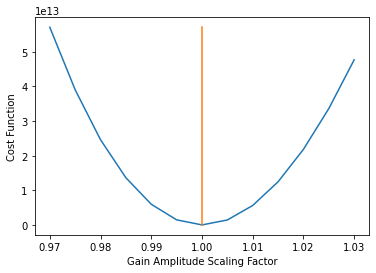

[1694.70096209 1676.75765381 1662.41105566 1651.50484272 1643.88913193
 1639.42020112 1637.96022137 1639.37700188 1643.54374682 1650.33882349
 1659.64554131 1671.35194089 1685.35059296]


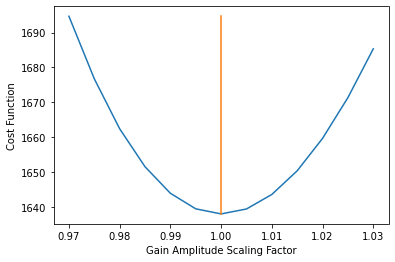

[2.57860982e+14 2.57860982e+14 2.57860982e+14 2.57860982e+14
 2.57860982e+14 2.57860982e+14 2.57860982e+14 2.57860982e+14
 2.57860982e+14 2.57860982e+14 2.57860982e+14 2.57860982e+14
 2.57860982e+14]


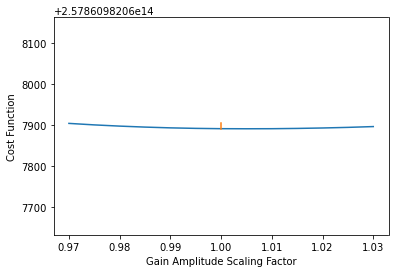

In [107]:
plt.figure()
for stddev_ind in range(3):
    use_trial = 0
    gains = gain_vals[:, use_trial, stddev_ind]+1
    visibilities = vis_diff_vals[:, use_trial, stddev_ind] + data_sim_vis_no_noise
    use_gain_amps = np.arange(1.-.03, 1.+.03, .005)
    cost_function_result = np.zeros(np.shape(use_gain_amps))
    for ind, use_gain_amp in enumerate(use_gain_amps):
        scaled_gains = gains*use_gain_amp
        scaled_visibilities = visibilities/use_gain_amp**2.
        #print(mean_gain_amp)
        x_result = np.concatenate((
            np.real(scaled_gains), np.imag(scaled_gains),
            np.real(scaled_visibilities), np.imag(scaled_visibilities)
        ))

        cost_function_result[ind] = cost_function(
            x_result, 
            N_red_baselines, N_ants, baseline_cov_inv, model_sim_visibilities, a_mat,
            gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev_use, model_stddev_use_vals[stddev_ind]
        )
    print(cost_function_result)
    cost_function_result_scaled = (cost_function_result-np.min(cost_function_result))/(np.max(cost_function_result)-np.min(cost_function_result))
    plt.plot(use_gain_amps, cost_function_result)
    plt.plot([1,1], [np.min(cost_function_result),np.max(cost_function_result)])
    plt.xlabel('Gain Amplitude Scaling Factor')
    plt.ylabel('Cost Function')
    #plt.ylim([0,1])
    plt.show()

In [ ]:
for stddev_ind in range(3):
    use_trial = 0
    gains = gain_vals[:, use_trial, 1]+1
    visibilities = vis_diff_vals[:, use_trial, 1] + data_sim_vis_no_noise
    mean_gain_amp = np.mean(np.abs(gains))
    use_gain_amps = np.arange(1.-.03, 1.+.03, .005)
    cost_function_result = np.zeros(np.shape(use_gain_amps))
    for ind, use_gain_amp in enumerate(use_gain_amps):
        scaled_gains = gains*use_gain_amp/mean_gain_amp
        scaled_visibilities = visibilities*(mean_gain_amp/use_gain_amp)**2.
        #print(mean_gain_amp)
        x_result = np.concatenate((
            np.real(scaled_gains), np.imag(scaled_gains),
            np.real(scaled_visibilities), np.imag(scaled_visibilities)
        ))

        cost_function_result[ind] = cost_function(
            x_result, 
            N_red_baselines, N_ants, baseline_cov_inv, model_sim_visibilities, a_mat,
            gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev_use, model_stddev_use_vals[stddev_ind]
        )
    print(cost_function_result)
    #cost_function_result_scaled = (cost_function_result-np.min(cost_function_result))/(np.max(cost_function_result)-np.min(cost_function_result))
    plt.plot(use_gain_amps, cost_function_result)
    #plt.plot([mean_gain_amp,mean_gain_amp], [0,1])
    plt.xlabel('Average Gain Amplitude')
    plt.ylabel('Cost Function')
    #plt.ylim([0,1])
    plt.show()

In [ ]:
stddev_ind = 2
gains = gain_vals[:, 0, stddev_ind]+1
visibilities = vis_diff_vals[:, 0, stddev_ind] + data_sim_vis_no_noise
gains*=1.01
visibilities/=1.01**2

fitted_visibilities_expanded = np.matmul(a_mat, visibilities)
gains_expanded = np.matmul(gains_exp_mat_1, gains)*np.matmul(gains_exp_mat_2, np.conj(gains))
prob = np.sum(np.abs(data_visibilities - gains_expanded*fitted_visibilities_expanded)**2)
print(prob/data_stddev_use**2)

vis_diff = visibilities-model_sim_visibilities
prior = np.abs(np.dot(np.matmul(np.conj(vis_diff), baseline_cov_inv), vis_diff))
print(prior/model_stddev_use_vals[stddev_ind]**2)

In [ ]:
bins = np.linspace(-.03, .03, num=100)
plt.hist(np.imag(gain_vals[:, :, 2]).flatten(), bins=bins)
#plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-.03, .03)
plt.show()

In [ ]:
colors = np.imag(np.mean(gain_vals[:, :, 2], axis=1))
print(colors)
plt.scatter(data_sim_expanded.antenna_positions[:,0], data_sim_expanded.antenna_positions[:,1], c=colors)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Gain Imaginary Value', rotation=270, labelpad=20)
plt.axes().set_aspect('equal')